# Сравнение оптимизации импульса переворота двух спинов методами GRAPE и CRUB

Основано на ноутбуке [qutip-notebooks/examples/control-pulseoptim-CRAB-2qubitInerac.ipynb](https://github.com/qutip/qutip-notebooks/blob/1286d50d476b20f41f7edeff4af1a1508f93f10d/examples/control-pulseoptim-CRAB-2qubitInerac.ipynb)

In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt

import qutip
from qutip.control.pulseoptim import opt_pulse_crab_unitary, optimize_pulse_unitary

In [2]:
Sx = qutip.sigmax()
Sz = qutip.sigmaz()

random.seed(20)
alpha = [random.random(), random.random()]
beta = [random.random(), random.random()]
H_d = (
    alpha[0] * qutip.tensor(Sx, qutip.identity(2))
    + alpha[1] * qutip.tensor(qutip.identity(2), Sx)
    + beta[0] * qutip.tensor(Sz, qutip.identity(2))
    + beta[1] * qutip.tensor(qutip.identity(2), Sz)
)

H_c = [qutip.tensor(Sz, Sz)]

q1_0 = q2_0 = qutip.Qobj([[1], [0]])
q1_targ = q2_targ = qutip.Qobj([[0], [1]])

psi_0 = qutip.tensor(q1_0, q2_0)
psi_targ = qutip.tensor(q1_targ, q2_targ)

In [3]:
psi_0

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]

In [4]:
psi_targ

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]]

In [5]:
n_ts = 100
evo_time = 18

In [6]:
fid_err_targ = 1e-3
max_iter = 500
max_wall_time = 120
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = "SQUARE"

## CRAB

In [7]:
%%time

result_crab = opt_pulse_crab_unitary(
    H_d,
    H_c,
    psi_0,
    psi_targ,
    n_ts,
    evo_time,
    fid_err_targ=fid_err_targ,
    max_iter=max_iter,
    max_wall_time=max_wall_time,
    init_coeff_scaling=5.0,
    num_coeffs=5,
    method_params={"xtol": 1e-3},
    guess_pulse_type=p_type,
    guess_pulse_action="modulate",
    # out_file_ext=f_ext,
    # log_level=log_level,
    gen_stats=True,
)

result_crab.fidelity, result_crab.fid_err

CPU times: user 2.8 s, sys: 35 ms, total: 2.83 s
Wall time: 716 ms


(0.0, 0.0008402525823328899)

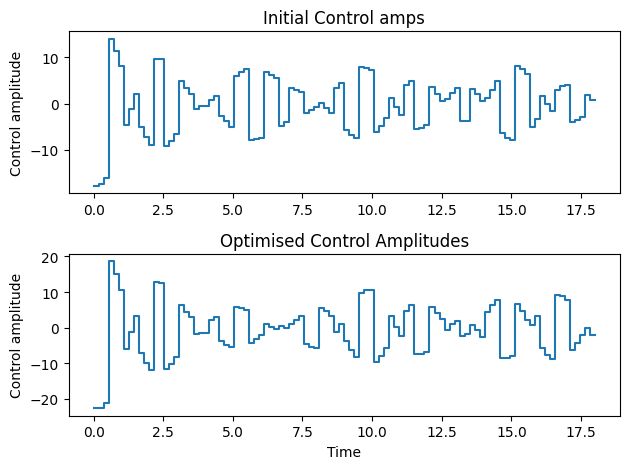

In [8]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(2, 1, 1)
ax1.set_title("Initial Control amps")
ax1.set_ylabel("Control amplitude")
ax1.step(
    result_crab.time,
    np.hstack((result_crab.initial_amps[:, 0], result_crab.initial_amps[-1, 0])),
    where="post",
)

ax2 = fig1.add_subplot(2, 1, 2)
ax2.set_title("Optimised Control Amplitudes")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control amplitude")
ax2.step(
    result_crab.time,
    np.hstack((result_crab.final_amps[:, 0], result_crab.final_amps[-1, 0])),
    where="post",
)
plt.tight_layout()
plt.show()

## GRAPE

In [9]:
%%time

min_grad = 1e-10

# or use `optimize_pulse` with  dyn_type='UNIT'
result_grape = optimize_pulse_unitary(
    H_d,
    H_c,
    psi_0,
    psi_targ,
    n_ts,
    evo_time,
    fid_err_targ=fid_err_targ,
    max_iter=max_iter,
    max_wall_time=max_wall_time,
    min_grad=min_grad,
    init_pulse_type=p_type,
    gen_stats=True,
)

result_grape.fidelity, result_grape.fid_err

CPU times: user 190 ms, sys: 239 ms, total: 429 ms
Wall time: 87.2 ms


(0.0, 0.0007818697646014838)

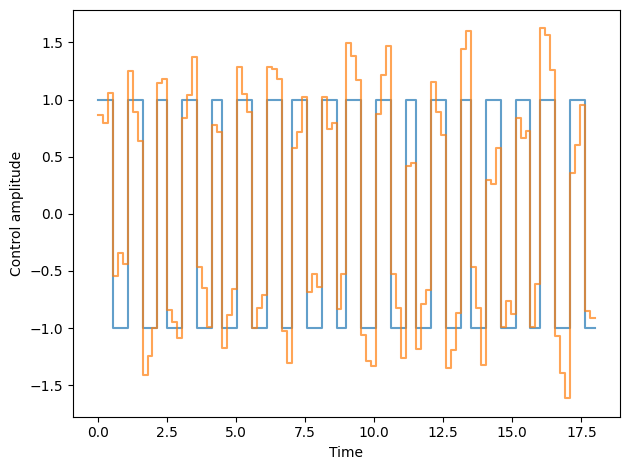

In [10]:
fig1 = plt.figure()
ax = fig1.add_subplot(1, 1, 1)
# ax1.set_title("Initial Control amps")
# ax.set_ylabel("Control amplitude")
ax.step(
    result_grape.time,
    np.hstack((result_grape.initial_amps[:, 0], result_grape.initial_amps[-1, 0])),
    where="post",
    alpha=0.7,
)

# ax2 = fig1.add_subplot(2, 1, 2)
# ax2.set_title("Optimised Control Amplitudes")
ax.set_xlabel("Time")
ax.set_ylabel("Control amplitude")
ax.step(
    result_grape.time,
    np.hstack((result_grape.final_amps[:, 0], result_grape.final_amps[-1, 0])),
    where="post",
    alpha=0.7,
)
plt.tight_layout()
plt.show()

## Эволюция фиделити: сравнение GRAPE и CRAB

In [11]:
t_list = np.linspace(0, evo_time, n_ts)
options = qutip.Options(nsteps=1e6)
evolution_grape = qutip.mesolve(
    [H_d, [H_c[0], result_grape.final_amps[:, 0]]],
    psi_0,
    t_list,
    options=options,
)

In [12]:
t_list = np.linspace(0, evo_time, n_ts)
options = qutip.Options(nsteps=1e6)
evolution_crap = qutip.mesolve(
    [H_d, [H_c[0], result_crab.final_amps[:, 0]]],
    psi_0,
    t_list,
    options=options,
)

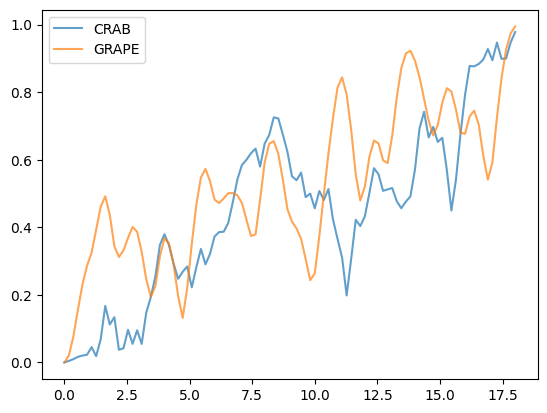

In [13]:
plt.plot(
    t_list,
    [qutip.metrics.fidelity(psi_targ, psi) for psi in evolution_crap.states],
    alpha=0.7,
    label="CRAB",
)

plt.plot(
    t_list,
    [qutip.metrics.fidelity(psi_targ, psi) for psi in evolution_grape.states],
    alpha=0.7,
    label="GRAPE",
)

plt.legend()

In [14]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.7.1
Numpy,1.24.2
SciPy,1.10.1
matplotlib,3.7.1
Cython,0.29.36
Number of CPUs,8
BLAS Info,OPENBLAS
IPython,8.14.0
Python,"3.11.5 (main, Aug 24 2023, 15:09:32) [Clang 14.0.0 (clang-1400.0.29.202)]"
OS,posix [darwin]
